In [2]:
#Imports

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm


C:\Users\isaac\Anaconda2\envs\cs281\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#A bandit model, consisting of reward coefficient mean, covariance, and \theta estimate.
class model:
    def __init__(self,mean,cov):
        self.mean = mean
        self.cov = cov
        self.theta = 0
        

        
#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self,params,prior_model,nInteract):
        #initialize everything
        self.pi_min = params[0]
        self.pi_max = params[1]
        self.v = 1e-1 #tuning parameter - multiplier on bandit prior covariances
        self.nInteract = nInteract
        
        #Initialize model to prior data model
        self.model = model(params[2]*prior_model.mean,np.eye(len(prior_model.mean)) + params[2]*prior_model.cov)
        #self.model.mean = params.prior_weight*prior_model.mean
        
        #self.model.cov = np.eye(model.n) + prior_weight*prior_model.cov
        
    ######
    
    def get_reward_func(self): #Do the regression to estimate reward function
        reg_coefs = np.dot(np.linalg.inv(self.model.cov) , self.model.mean) #Regression estimate
        self.model.theta = reg_coefs[:self.nInteract]
        return self.model
    
    #####
    
    def update_model(self, featVec,reward, missing_data_flags, action,prob):
        #Thompson sampling eqns
        fTilde = np.concatenate((action * featVec[:self.nInteract].reshape((-1, 1)), featVec.reshape((-1, 1))), axis=0)
        
        self.model.mean = self.model.mean + fTilde*reward #featVec.reshape((-1, 1))*reward * (action - 0*prob)
        self.model.cov = self.model.cov + (np.outer(fTilde , fTilde)) #
        
        

        
        
########
#Utility function to get action probability on user side. Does not affect class or object
def action_probability(featVec,bandit):
    current_model = bandit.get_reward_func()
    
    #Probability of Gaussian scalar exceeding threshold
    featInteract = featVec[:bandit.nInteract]
    mean = np.dot( featInteract, current_model.theta)
    cv = np.linalg.inv(current_model.cov)
    variance = bandit.v**2 * np.dot(featInteract.transpose() , np.dot(cv[:bandit.nInteract,:bandit.nInteract], featInteract.reshape((-1, 1))))
    pi_0 = 1-norm.cdf(0, mean, np.sqrt(variance))
    #print current_model.theta.shape
    if pi_0 < bandit.pi_min:
        alpha = bandit.pi_min
    elif pi_0 > bandit.pi_max:
        alpha = bandit.pi_max
    else: 
        alpha = pi_0
        
    return alpha #probability of taking action 1

#######


In [4]:
# HS Analysis Functions




### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer):
    pd_df = pd.read_csv('../../Data/suggest-analysis-kristjan.csv') #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer):
    pd_df = pd.read_csv('../../Data/suggest-kristjan.csv') #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()

def read_data(N, T, t, nBaseline):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    # Bias term

    for yoozer in range(1,max_yoozer):
    #     print("Processeing User: ", yoozer)

        ddf,pd_df = read_hs1(yoozer)
        #Make features
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        #total_sent = ddf['totalSent']
        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = (ddf['study.day.nogap'] - np.mean(pd_df['study.day.nogap']))/np.std(pd_df['study.day.nogap'])#Number sent in last whatever
        #Add feature for # of week period (hsteps v2) WATCH OUT FOR COLINEARITY WITH INTERCEPT

        # Ohter location indicator
        loc_ind = ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = (ddf['window7.steps60.sd'] - np.mean(pd_df['window7.steps60.sd']))/np.std(pd_df['window7.steps60.sd'])

        # Step count in previous 30 minutes
        state = (ddf['jbsteps30pre.log'] - np.mean(pd_df['jbsteps30pre.log']))/np.std(pd_df['jbsteps30pre.log'])

        # Work location indicator
        #wrk_ind = ddf['location.category'], #loc_ind = ddf['location.category']
        wrk_ind = ddf['loc.is.work'] #compare to string “work”

        # Square root steps yesterday
        steps_yest = (ddf['steps.yesterday.sqrt'] - np.mean(pd_df['steps.yesterday.sqrt']))/np.std(pd_df['steps.yesterday.sqrt'])

        # Temperature, set -1024 as 0
        temp = (ddf['temperature'] - np.mean(pd_df['temperature']))/np.std(pd_df['temperature'])
        temp[ddf['temperature'] == -1024] = 0

        ddfgf,pd_dfgf = read_hs1_gf(yoozer)

        # ?? Unclear what this is
        # Reward: Step count in 30 minutes following decision point
        steps_gf = (np.log(ddfgf['gfsteps30pre'] + .5) - np.mean(np.log(pd_dfgf['gfsteps30pre'] + .5))/np.std(np.log(pd_dfgf['gfsteps30pre']+.5)))

        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind.astype(int) # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd.astype(float) # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind.astype(int) # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp.astype(float) # temperature

        # This was included but didn't make too much sense
    #     featVec[yoozer,:end_ind,8] = steps_gf.astype(float)[:day_ind.shape[0]]
    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \theta, where s' are interact terms and s are all baseline
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = np.concatenate([(A * S[:,:,1:1+nInteract]), S], 2).reshape((N*T*t,(nInteract + nBaseline))), missing = "drop")
    resids = resid_model.fit().resid

    # Parameters
    Thetas_fit = resid_model.fit().params


    ## Fill Eta ##

    # Copy shape and location of nans
    Eta = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        Eta[n][:curr_ind-old_ind] = resids[old_ind:curr_ind]
    
    return Eta, Thetas_fit


# # Code to Generate Simulated Users
def generate_new_users(Eta, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user
    
    Inputs:
        Eta: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        Eta_new: Matrix of Etas for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      Eta: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate Eta, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(Eta,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    Eta_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return Eta_new, A_new, S_new


# Generate new Users
# T_new = 90



def reward_func(eta, a, s, Theta, nInteract = 3):
    '''Basic reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.'''
    return(eta + np.concatenate([a * np.take(s,range(1,1+nInteract),-1), s], a.ndim-1).dot(Theta))



In [5]:
## Creating Simulations

# Counts from HS 1
N = 48
T = 41
t = 5
nBaseline = 1+7
nInteract = 3 # Add 1 for bias term

N_new = 20
T_new = 90

S, R, A = read_data(N, T, t, nBaseline)
Eta, Thetas_fit = resid_regression(N, T, t, nBaseline, R, A, S)
Eta_new, A_new, S_new = generate_new_users(Eta, A, S, 20, 90, T, t)

print("Done")


C:\Users\isaac\Anaconda2\envs\cs281\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (15,16,18,60,61,96,97,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Done


In [6]:
# VARIABLES FROM ABOVE CELL

S_new # Baseline States for simulated users
Eta_new # Residuals; note this does not match up with Kristjan's Eta definition (he treats this as baseline OLS coefficient)

# Thetas[0:3] is action*interact features
# Thetas[3] is state bias (1's)
# Thetas[4:11] are baseline features
Thetas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

In [7]:
#Create a reward function from true coefficients, with residuals non-mandatory
def reward(featVec,action,coef0,coef1, resid = 0):
    
    nInteract = len(coef1)
    
    predictors = np.concatenate([action * np.take(featVec,range(1,1+nInteract),-1), featVec], 0)
    Theta = np.concatenate([coef1, coef0])
    
    return(resid + np.dot(predictors, Theta))

In [8]:
#A simulation.

def run_simulation(coef0, coef1, S_sim, resids_sim, reward_func, nInteract = 3, nBaseline = 7+1,
                   params = [.2, .8, 0], T = 90, t = 5, no_resid = False):
    '''
    coef0: Reward coefficients for baseline (ETA), first elemnet is bias term
    coef1: Reward coefficients for interaction (THETA)
    resids_sim: Residuals of simulated users
    reward_func: reward function, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features
    nBaseline: Number of baseline features
    params: Bandit parameters; [minprob, maxprob, priorweight]
    T: days of study
    t: decision points per day
    no_resid: If True will substitute 0 for residuals, if False will use true residuals
    '''

    N, T, t = S_sim.shape[:-1]
    
    assert nBaseline == S_sim.shape[-1]
    
    #creating variables for saving history of what we do
    regret = np.empty((N, T, t))
    probs  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    regret.fill(np.nan)
    probs.fill(np.nan)
    action.fill(np.nan)

    for sim_user_index in range(N):

        #Create a bandit object for each user
        prior_mdl= model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline)) #Initialize bandit to very simple prior distribution
        bandit = ContextBandit(params,prior_mdl,nInteract) #Create and initialize bandit

        #Cycle thru days
        for day in range(T):

            rwd = np.zeros(t)
            featVec = np.zeros((nBaseline,t))
            #Cycle thru decision points in each day
            for dpt in range(t):
                #Generate random state vector 
                featVec[:,dpt] = S_sim[sim_user_index, day, dpt]
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                #ISAAC: probs[] is the probability of taking action 1 at current decision point, i.e. \pi_t(1|s_t) in the doc (Quality metrics 1&2).
                featInteract = featVec[1:1+nInteract,dpt] #only use the interaction features, but first element is bias
                if 0: #Do nothing
                    probs[sim_user_index, day, dpt] = 0
                else: #Use bandit
                    probs[sim_user_index, day, dpt] = action_probability(featInteract,bandit)


                #Choose action based on probability, i.e. do the randomization
                if np.random.rand() < probs[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. As written has Gaussian noise - Isaac remove (can use 0 instead of sig).  Done.
                #ISAAC: Insert simulated user residuals here, as the "noise".
                rwd[dpt] = reward(featVec[:,dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)
                rwd[dpt] = reward(featVec[:,dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)


                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward(featVec[:,dpt], 0, coef0, coef1, user_resid) # do we want to include user_resid here or use default 0?
                rwd1 = reward(featVec[:,dpt], 1, coef0, coef1, user_resid)

                #Expected reward under bandit policy
                rwdExp = probs[sim_user_index, day, dpt]*rwd1 + (1-probs[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                #"Optimal" reward is restricted based on the min/max allowed probabilities
                #ISAAC: THIS IS THE REGRET AT THE CURRENT DECISION POINT. Cumulative regret is formed by summing this up from time 0 to the current time.
                regret[sim_user_index,  day, dpt] = max(params[0]*rwd0 + params[1]*rwd1, params[0]*rwd1 + params[1]*rwd0) - rwdExp


            #Perform bandit updates at end of day
            for dpt in range(t):

                bandit.update_model(featVec[:,dpt],rwd[dpt],np.zeros(nInteract+nBaseline),action[sim_user_index, day, dpt],probs[sim_user_index, day, dpt])


    return regret.reshape((N,T*t)), probs.reshape((N,T*t)), action.reshape((N,T*t))


In [9]:
regret, probs, action = run_simulation(coef0 = Thetas_fit[3:11], coef1 = Thetas_fit[0:3], S_sim = S_new, resids_sim = Eta_new, reward_func = reward)

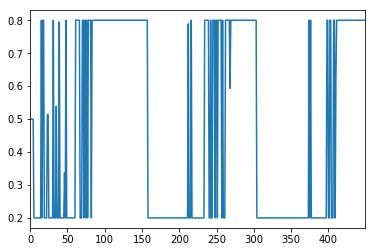

In [20]:
# Probability of 
pd.DataFrame(probs.T).iloc[:,0].plot()



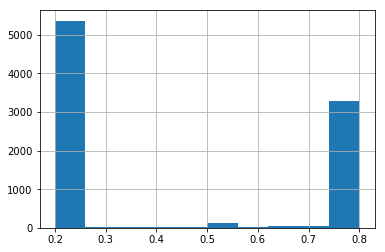

In [37]:
# Hist of probabilities
pd.Series(probs.flatten()).hist()

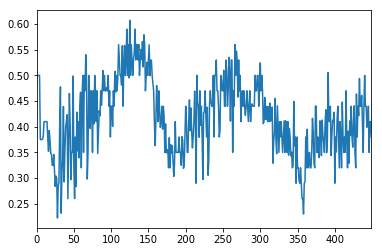

In [49]:

# Plot of mean (over users) probability over time
pd.Series(np.mean(probs, axis = 0)).plot()



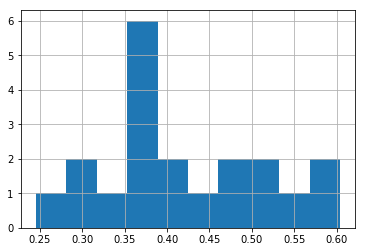

In [52]:
# Histogram of mean probabilities per user
pd.Series(np.mean(probs, axis = 1)).hist()

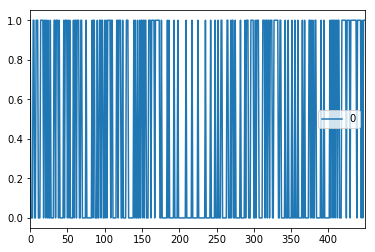

In [46]:
# Actions actually taken
pd.DataFrame(action[0].T).plot()

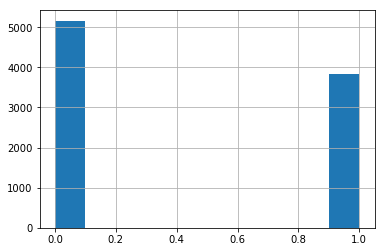

In [47]:
pd.Series(action.flatten()).hist()

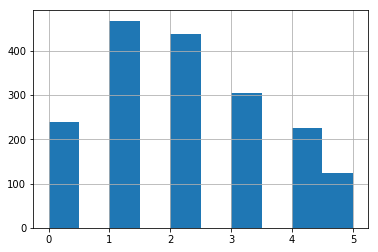

In [42]:
# Hist of number of actions taken per day (out of 5)
pd.Series(np.sum(action.reshape((N_new, T_new, t)), axis = 2).flatten()).hist()



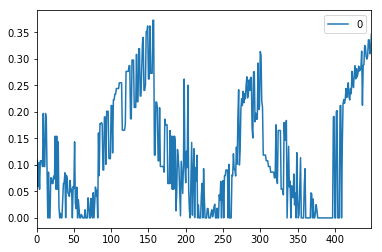

In [32]:
pd.DataFrame(regret[0].T).plot()

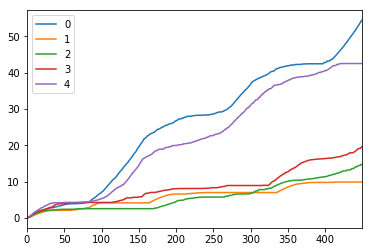

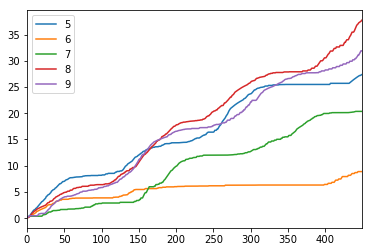

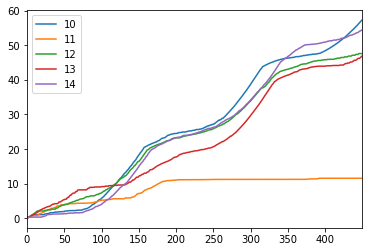

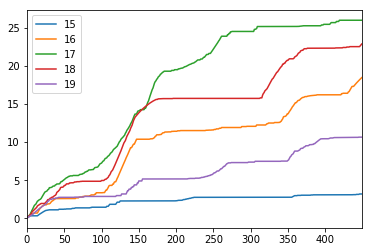

In [31]:
# Cumulative regret for users
for i in range(N_new):
    if i%5 == 0:
        (np.cumsum(pd.DataFrame(regret), axis = 1))[i:i+5].T.plot()
    
    